In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
! pip3 install openpyxl

  Using cached openpyxl-3.0.10-py2.py3-none-any.whl (242 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [2]:
df1 = pd.read_excel('Consolidated MEVs.xlsx', engine='openpyxl',sheet_name='Baseline')
df2 = pd.read_csv('mortgagedatacorrectdate.csv')

print(df1.shape)
print(df2.shape)

(540, 127)
(2225652, 4)


In [3]:
df1.Date = pd.to_datetime(df1.Date)
df2.Date = pd.to_datetime(df2.Date)

df1.Date = df1['Date'].dt.strftime('%m/%Y')
df2.Date = df2['Date'].dt.strftime('%m/%Y')


In [4]:
merged_df = pd.merge(df1, df2, on='Date', how='inner')

print(merged_df.shape)

(2225652, 130)


In [5]:
#delete date column
merged_df = merged_df.drop('Date', axis=1)

In [8]:
# check data imbalance
merged_df['def_trig'].value_counts()/merged_df['def_trig'].shape[0]

0    0.999288
1    0.000712
Name: def_trig, dtype: float64

In [27]:
sample_df = merged_df.groupby(['def_trig']).apply(lambda f: f.sample(frac=0.1)) # 10% sample

In [28]:
# check data imbalance
sample_df['def_trig'].value_counts()/sample_df['def_trig'].shape[0]

0    0.99929
1    0.00071
Name: def_trig, dtype: float64

In [30]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(sample_df['def_trig']), y=sample_df['def_trig'])

In [31]:
class_weights

array([5.00355205e-01, 7.04319620e+02])

In [35]:
print("{:.3f}".format(round(class_weights[0], 3)))
print("{:.3f}".format(round(class_weights[1], 3)))
# print({':.3f'}.format(class_weights[0]))

0.500
704.320


In [36]:
#splitting dependent & independent variables:
X =  sample_df.loc[:, sample_df.columns != 'def_trig'].values
y = sample_df.loc[:, sample_df.columns == 'def_trig'].values

In [38]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

In [42]:
#scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
#training Logistic Regression Model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, class_weight = {0:0.500,1:704.320})
classifier.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.5, 1: 704.32}, random_state=0)

In [44]:
#pedict test set results
y_pred = classifier.predict(X_test)

In [45]:
#confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[35225 20377]
 [   21    19]]


0.6334064196110851

In [6]:
merged_df.isna().sum().sort_values(ascending=False)

M97              0
M172             0
M306             0
M305             0
M304             0
                ..
M138             0
M230             0
M229             0
M135             0
dummylockdown    0
Length: 129, dtype: int64

In [51]:
from sklearn.metrics import recall_score

print(recall_score(y_pred,y_test))



0.0009315552069033144


### scorecardpy functions testing

In [7]:
import scorecardpy as sc

In [8]:
merged_df = merged_df.iloc[:120000,70:]

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 59 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   M270           120000 non-null  float64
 1   M271           120000 non-null  float64
 2   M272           120000 non-null  float64
 3   M273           120000 non-null  float64
 4   M274           120000 non-null  float64
 5   M182           120000 non-null  float64
 6   M276           120000 non-null  float64
 7   M277           120000 non-null  float64
 8   M185           120000 non-null  float64
 9   M279           120000 non-null  float64
 10  Date.1         120000 non-null  int64  
 11  M283           120000 non-null  float64
 12  M284           120000 non-null  float64
 13  M285           120000 non-null  float64
 14  M286           120000 non-null  float64
 15  M290           120000 non-null  float64
 16  M291           120000 non-null  float64
 17  M292           120000 non-nul

In [9]:
dt_s = sc.var_filter(merged_df, y="def_trig")


[INFO] filtering variables ...


In [10]:
%%time
# breaking dt into train and test
train, test = sc.split_df(merged_df, 'def_trig').values()

CPU times: user 15.3 s, sys: 34 ms, total: 15.4 s
Wall time: 15.4 s


In [12]:
dt_s.head()

,M345,M270,M321,M334,M284,M357,M319,M276,M326,M304,...,M358,M368,M359,M320,M286,M347,M325,M274,M271,def_trig
0,1.204384,0.011971,8.333076,-2.962856,9.849173,-43.34431,5.684209,-0.370454,8.7819,3.721994,...,-8.853089,-6.980494,-54.699951,5.684209,7.305764,9.780168,2.074085,-0.286168,0.977721,0
1,1.204384,0.011971,8.333076,-2.962856,9.849173,-43.34431,5.684209,-0.370454,8.7819,3.721994,...,-8.853089,-6.980494,-54.699951,5.684209,7.305764,9.780168,2.074085,-0.286168,0.977721,0
2,1.204384,0.011971,8.333076,-2.962856,9.849173,-43.34431,5.684209,-0.370454,8.7819,3.721994,...,-8.853089,-6.980494,-54.699951,5.684209,7.305764,9.780168,2.074085,-0.286168,0.977721,0
3,1.204384,0.011971,8.333076,-2.962856,9.849173,-43.34431,5.684209,-0.370454,8.7819,3.721994,...,-8.853089,-6.980494,-54.699951,5.684209,7.305764,9.780168,2.074085,-0.286168,0.977721,0
4,1.204384,0.011971,8.333076,-2.962856,9.849173,-43.34431,5.684209,-0.370454,8.7819,3.721994,...,-8.853089,-6.980494,-54.699951,5.684209,7.305764,9.780168,2.074085,-0.286168,0.977721,0


In [13]:
dt_s.columns

Index(['M345', 'M270', 'M321', 'M334', 'M284', 'M357', 'M319', 'M276', 'M326',
       'M304', 'M370', 'M318', 'M293', 'M344', 'M291', 'M333', 'M356', 'M332',
       'M307', 'M279', 'M335', 'M290', 'Date.1', 'M296', 'M305', 'M317',
       'M361', 'M369', 'M301', 'M182', 'M355', 'MOB', 'M277', 'M306', 'M285',
       'M330', 'M185', 'M272', 'M303', 'M294', 'M283', 'M314', 'M324', 'M292',
       'M311', 'M346', 'M328', 'M273', 'M358', 'M368', 'M359', 'M320', 'M286',
       'M347', 'M325', 'M274', 'M271', 'def_trig'],
      dtype='object')

In [14]:
dt_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 58 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   M345      120000 non-null  float64
 1   M270      120000 non-null  float64
 2   M321      120000 non-null  float64
 3   M334      120000 non-null  float64
 4   M284      120000 non-null  float64
 5   M357      120000 non-null  float64
 6   M319      120000 non-null  float64
 7   M276      120000 non-null  float64
 8   M326      120000 non-null  float64
 9   M304      120000 non-null  float64
 10  M370      120000 non-null  float64
 11  M318      120000 non-null  float64
 12  M293      120000 non-null  float64
 13  M344      120000 non-null  float64
 14  M291      120000 non-null  float64
 15  M333      120000 non-null  float64
 16  M356      120000 non-null  float64
 17  M332      120000 non-null  float64
 18  M307      120000 non-null  float64
 19  M279      120000 non-null  float64
 20  M335

In [15]:
dt_s = dt_s.drop('M361',axis=1)

In [16]:
%%time
# woe binning ------
bins = sc.woebin(dt_s, y="def_trig")
# sc.woebin_plot(bins)

[INFO] creating woe binning ...
Binning on 120000 rows and 57 columns in 00:00:18
CPU times: user 15.7 s, sys: 311 ms, total: 16 s
Wall time: 18.9 s


/home/amol-murme/SBM/myenv/lib/python3.10/site-packages/scorecardpy/woebin.py:1225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


CPU times: user 2.24 s, sys: 35.2 ms, total: 2.28 s
Wall time: 2.27 s


{'M345': <Figure size 640x480 with 2 Axes>,
 'M270': <Figure size 640x480 with 2 Axes>,
 'M321': <Figure size 640x480 with 2 Axes>,
 'M334': <Figure size 640x480 with 2 Axes>,
 'M284': <Figure size 640x480 with 2 Axes>,
 'M357': <Figure size 640x480 with 2 Axes>,
 'M319': <Figure size 640x480 with 2 Axes>,
 'M274': <Figure size 640x480 with 2 Axes>,
 'M326': <Figure size 640x480 with 2 Axes>,
 'M370': <Figure size 640x480 with 2 Axes>,
 'M304': <Figure size 640x480 with 2 Axes>,
 'M276': <Figure size 640x480 with 2 Axes>,
 'M318': <Figure size 640x480 with 2 Axes>,
 'M293': <Figure size 640x480 with 2 Axes>,
 'M344': <Figure size 640x480 with 2 Axes>,
 'M291': <Figure size 640x480 with 2 Axes>,
 'M333': <Figure size 640x480 with 2 Axes>,
 'M356': <Figure size 640x480 with 2 Axes>,
 'M332': <Figure size 640x480 with 2 Axes>,
 'M307': <Figure size 640x480 with 2 Axes>,
 'M279': <Figure size 640x480 with 2 Axes>,
 'M335': <Figure size 640x480 with 2 Axes>,
 'M290': <Figure size 640x480 wi

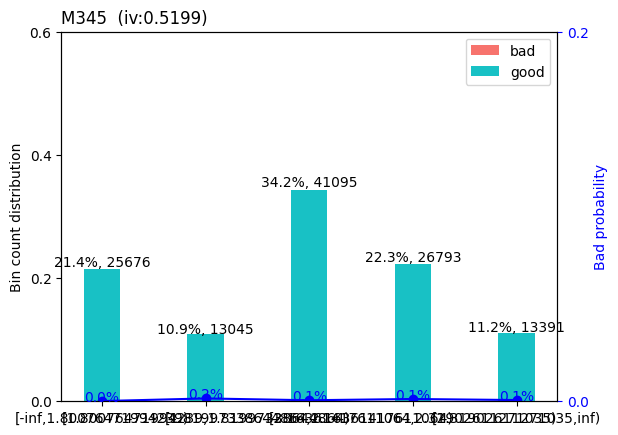

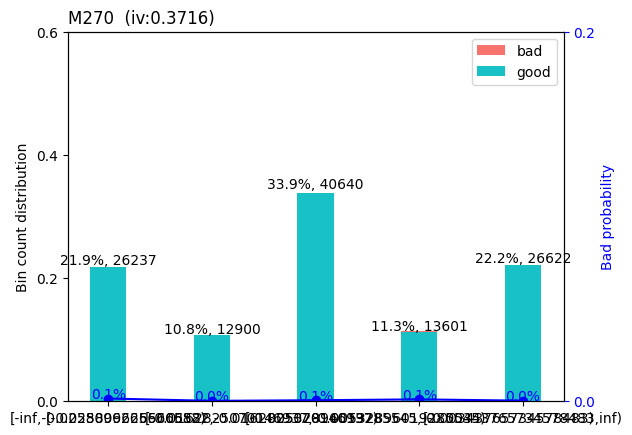

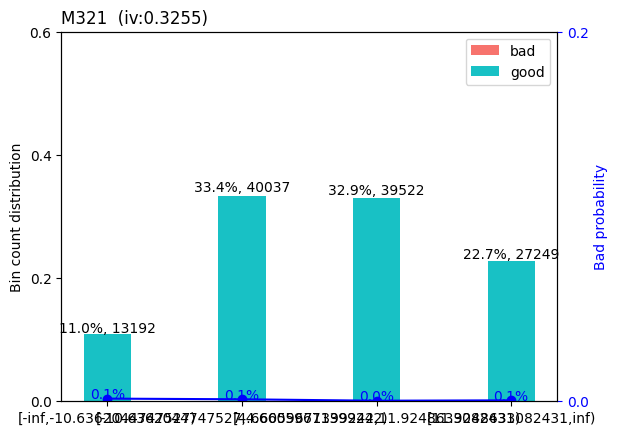

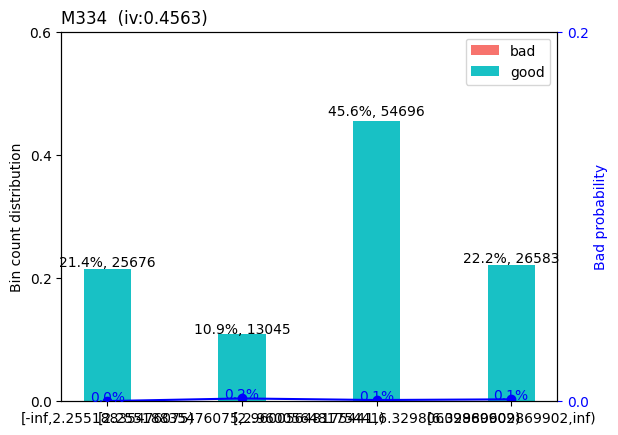

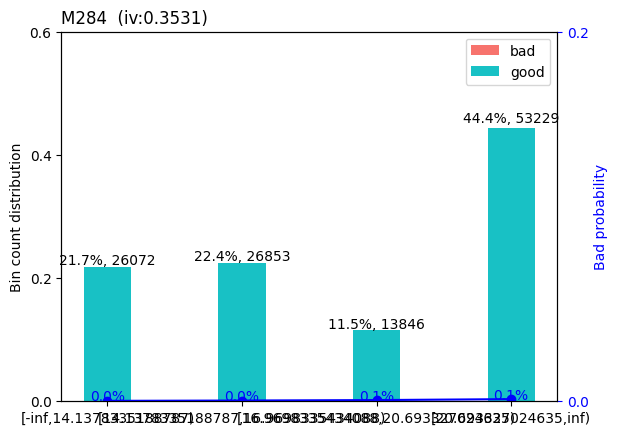

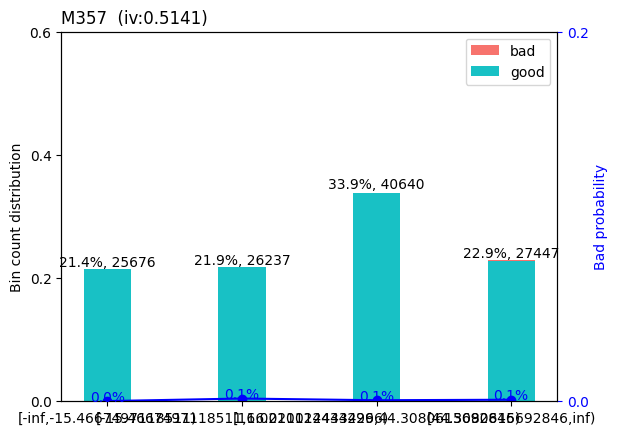

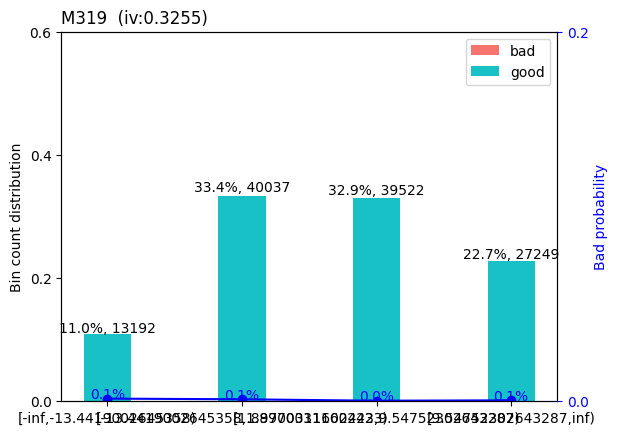

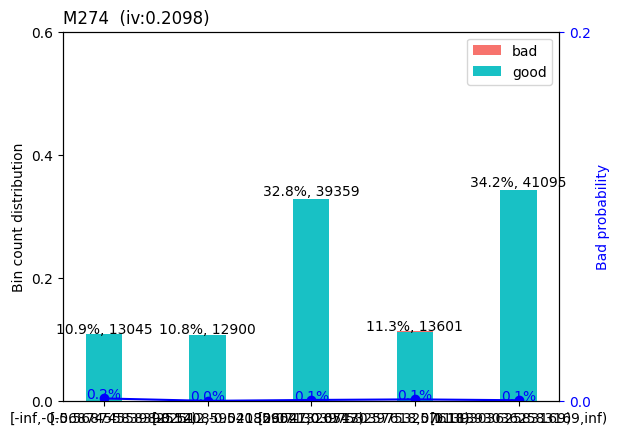

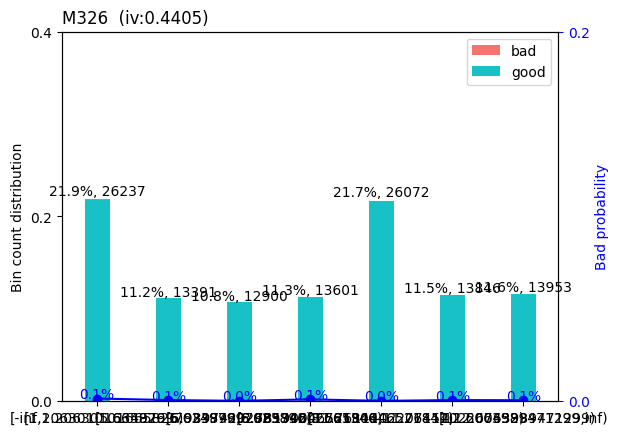

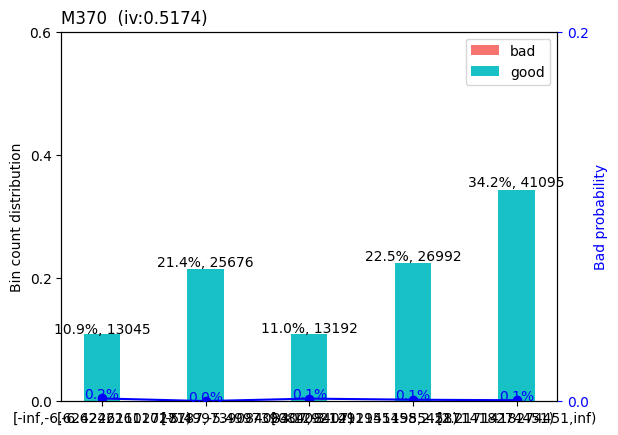

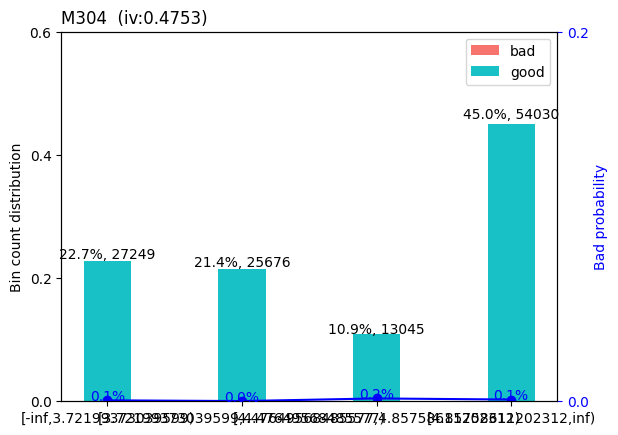

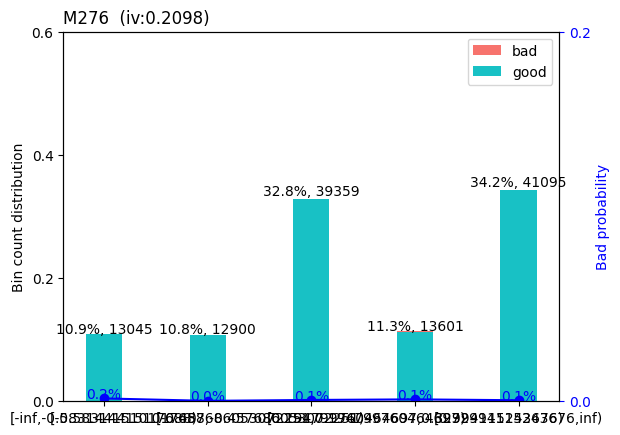

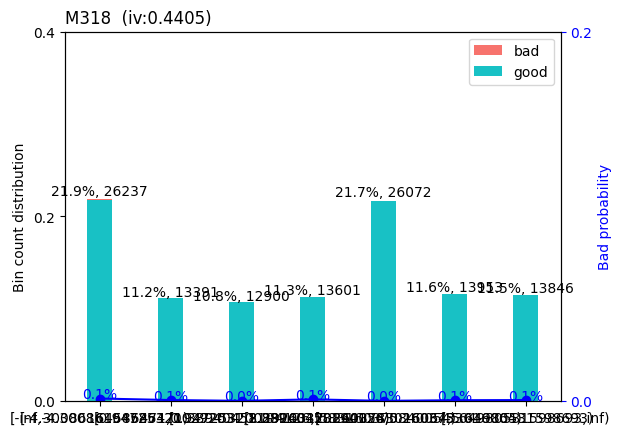

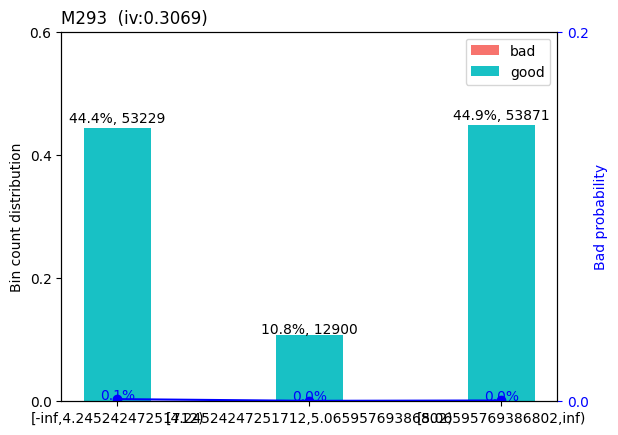

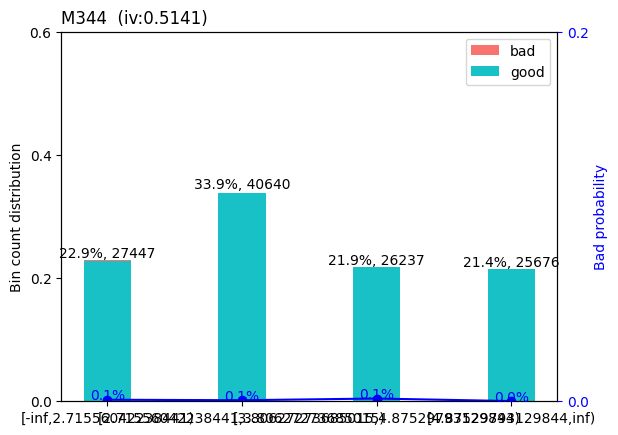

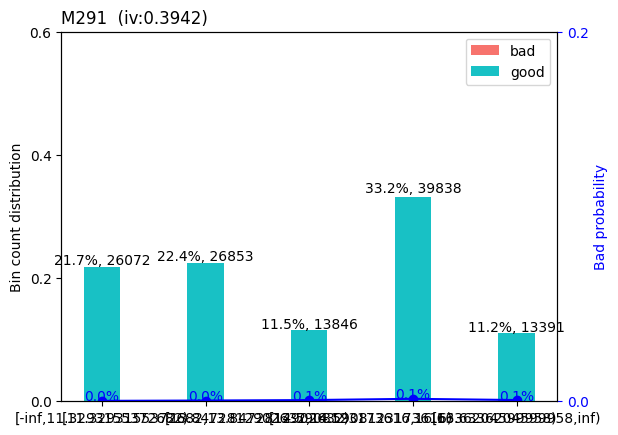

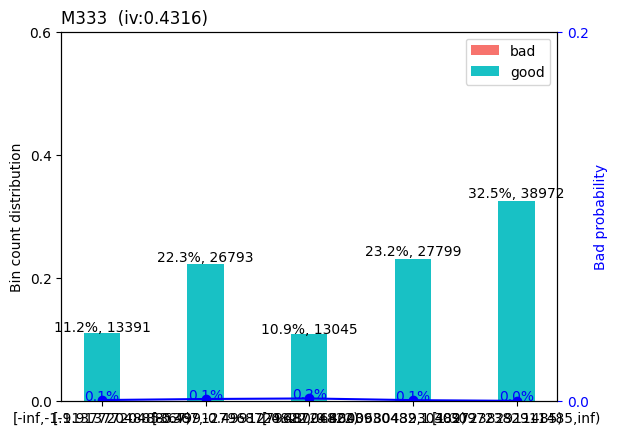

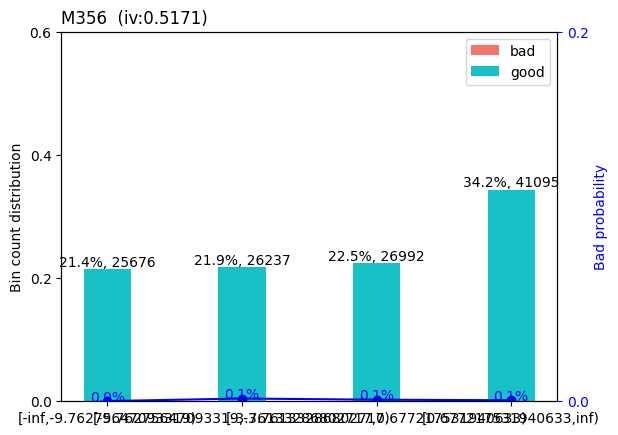

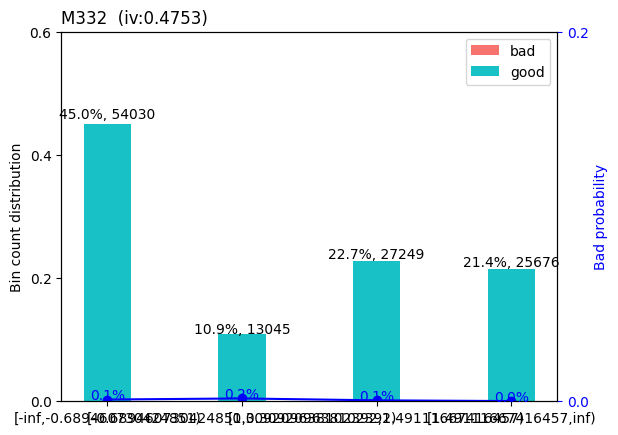

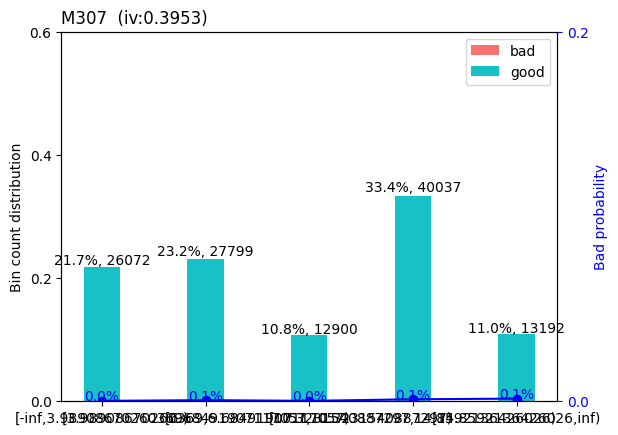

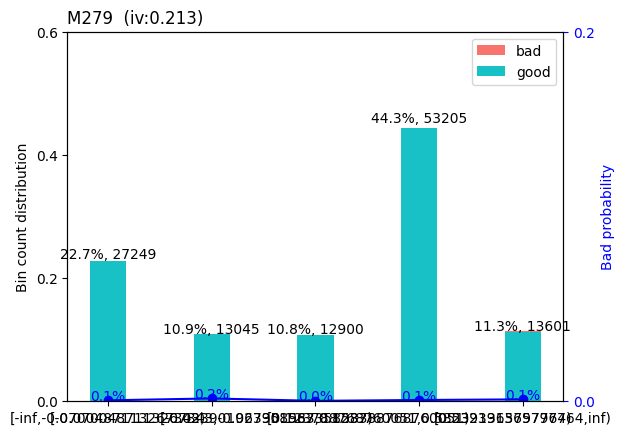

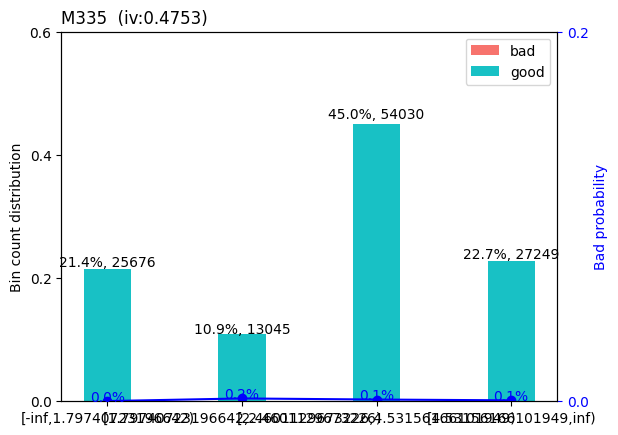

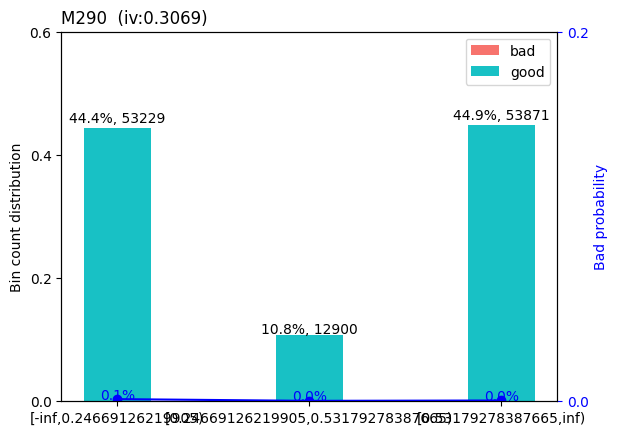

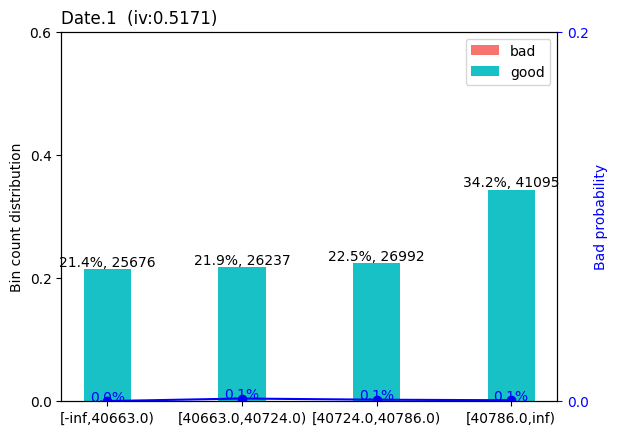

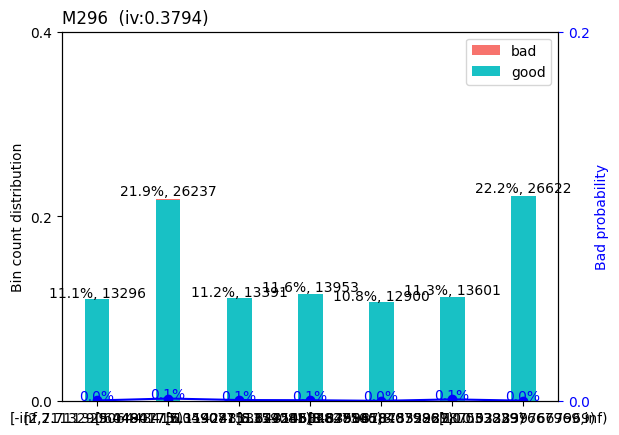

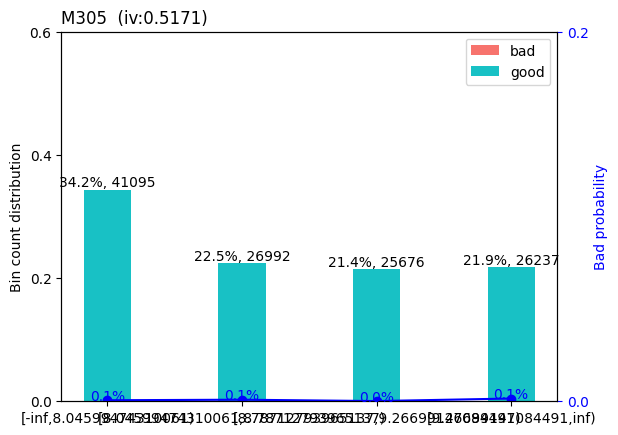

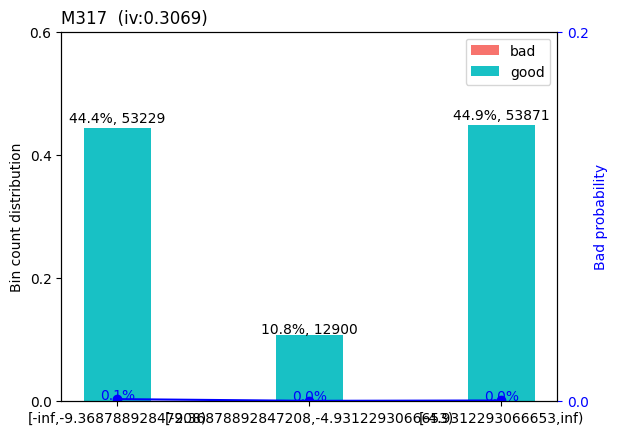

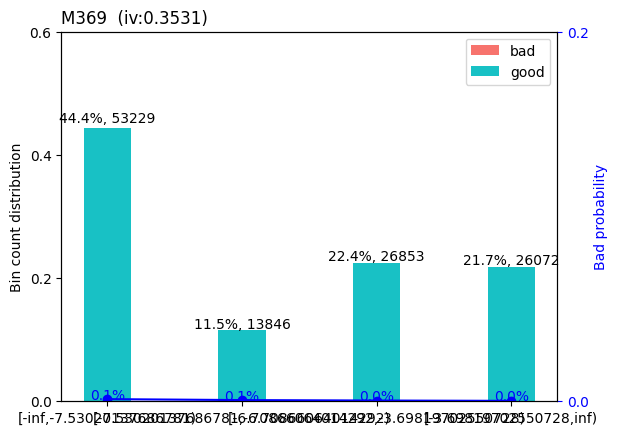

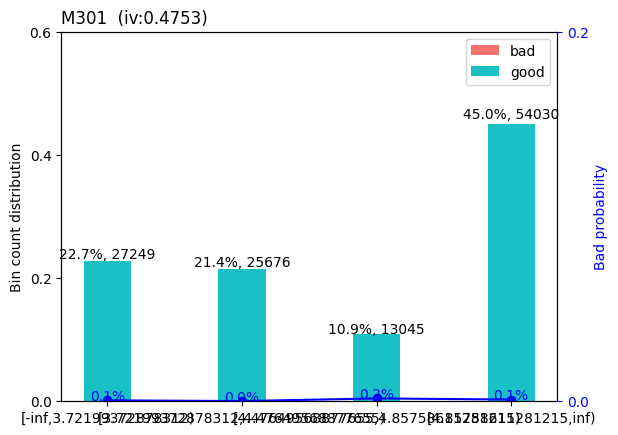

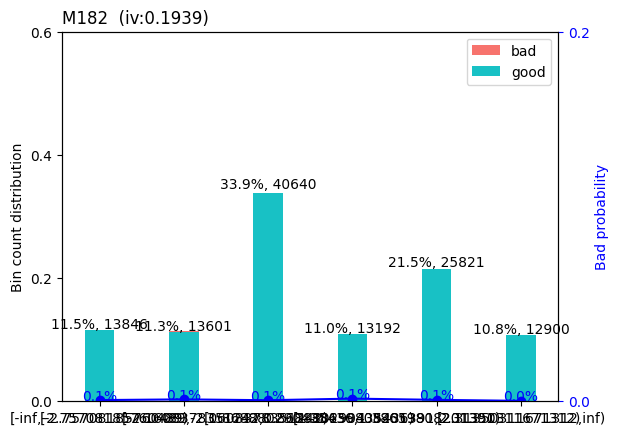

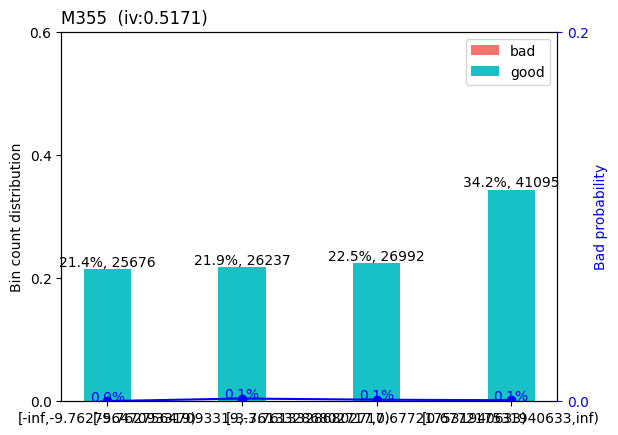

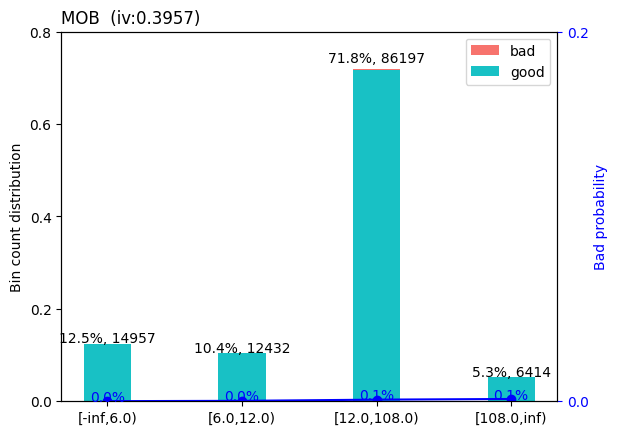

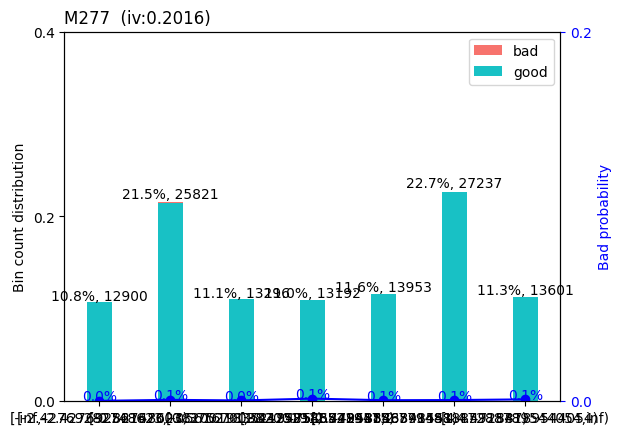

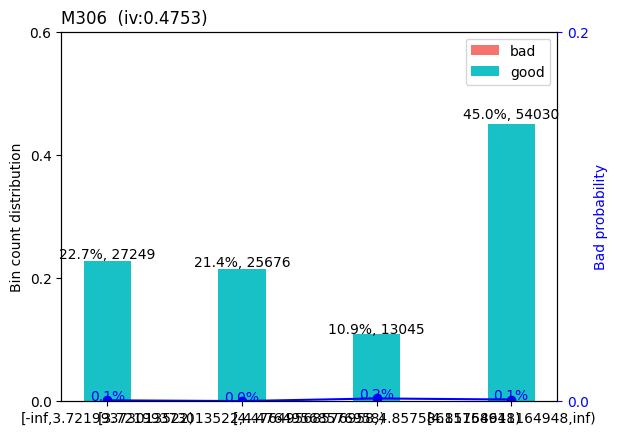

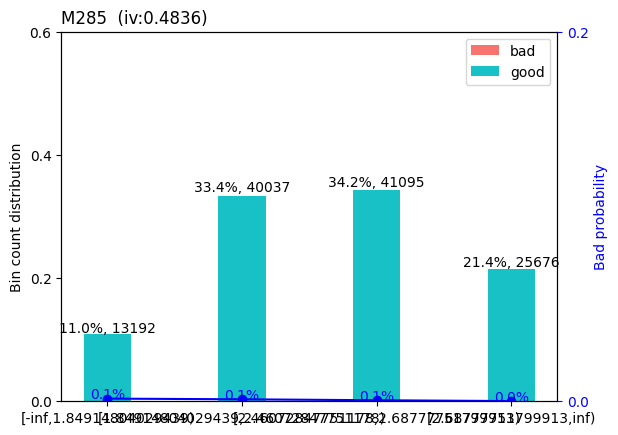

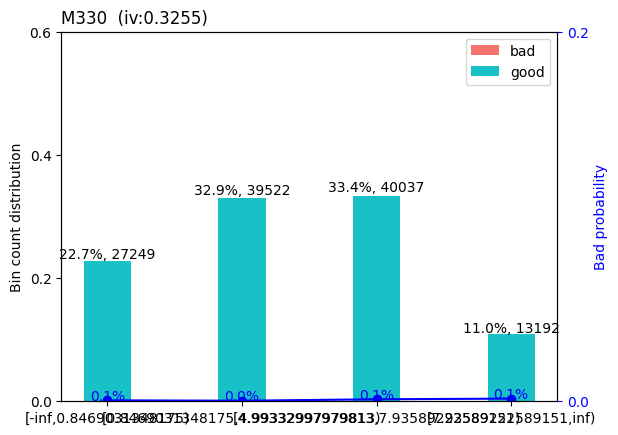

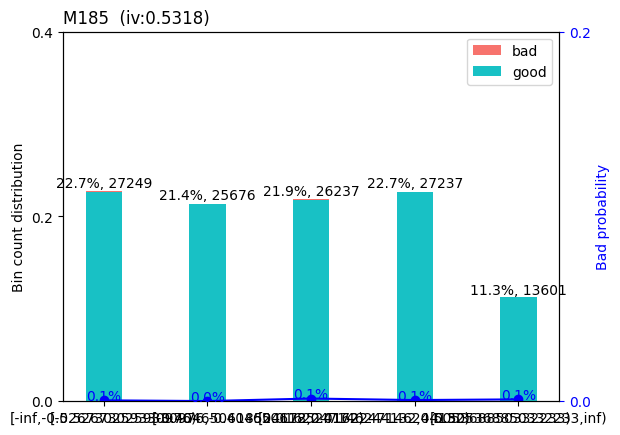

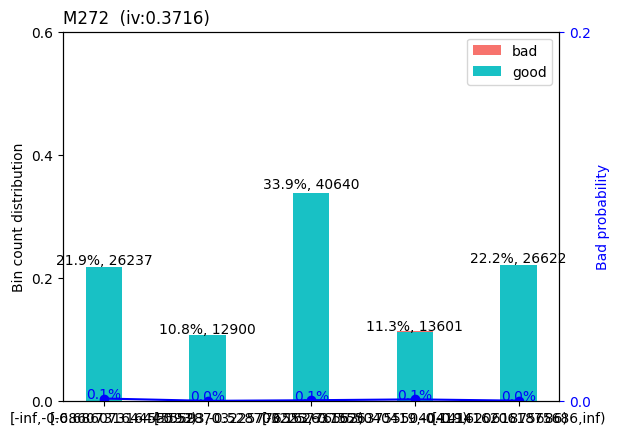

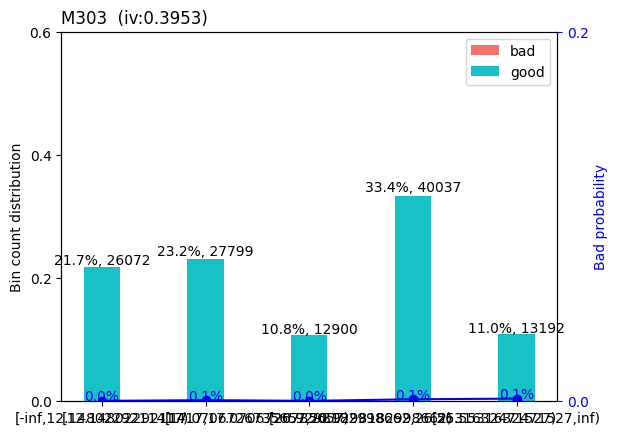

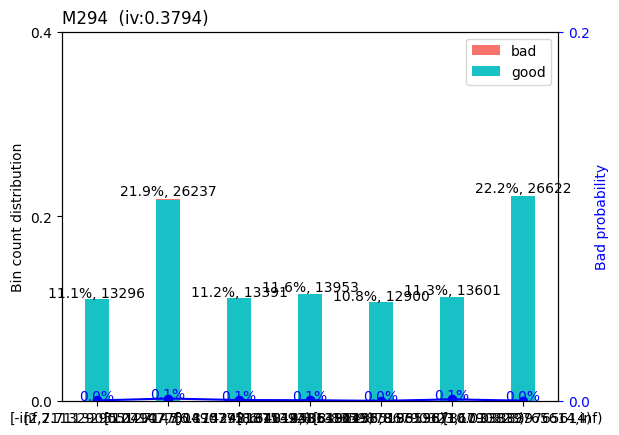

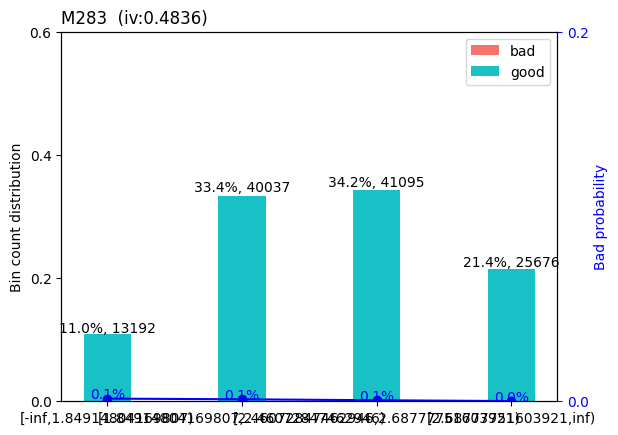

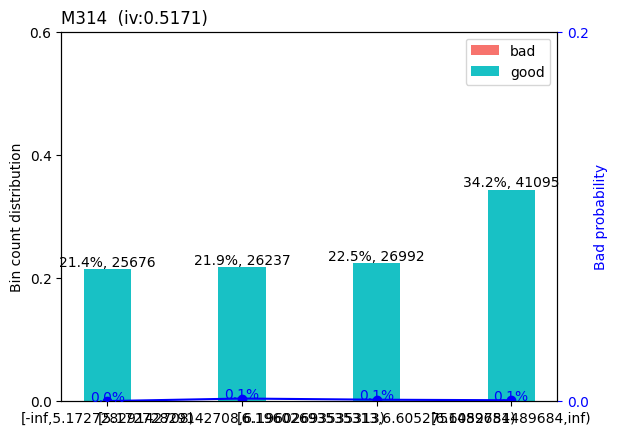

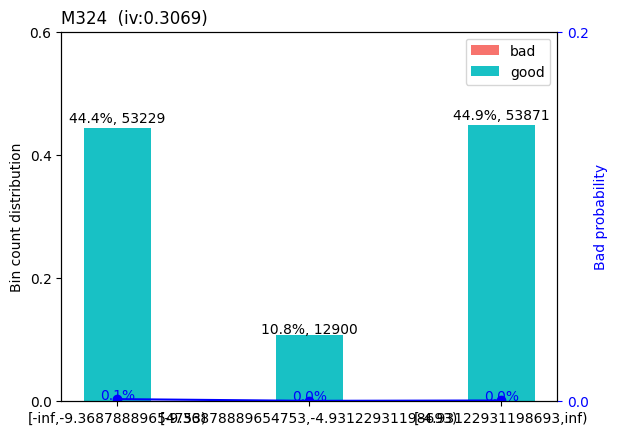

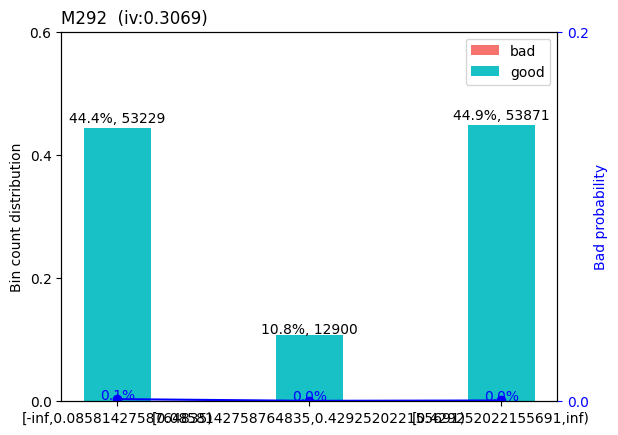

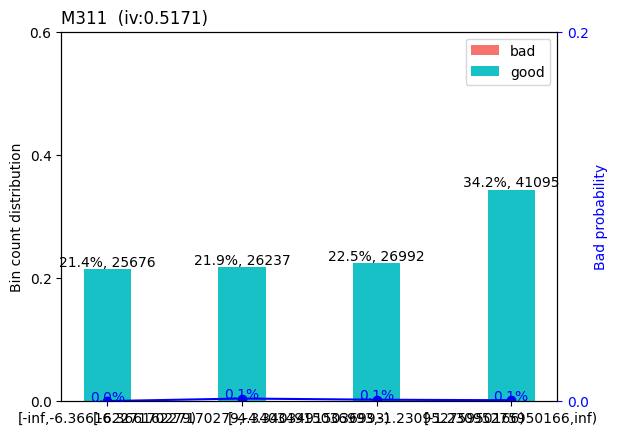

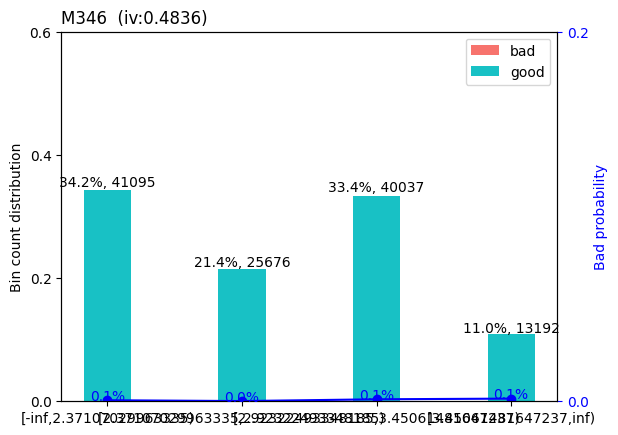

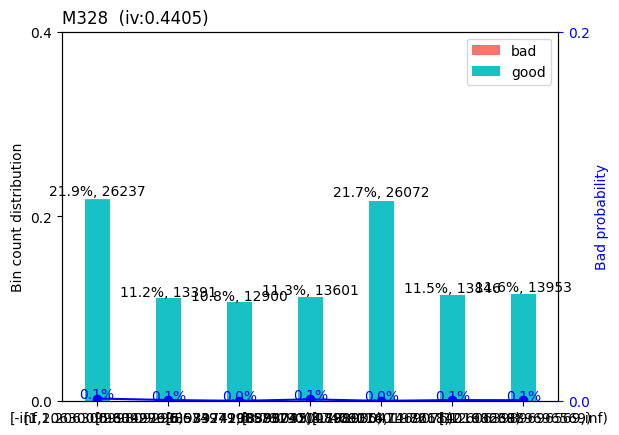

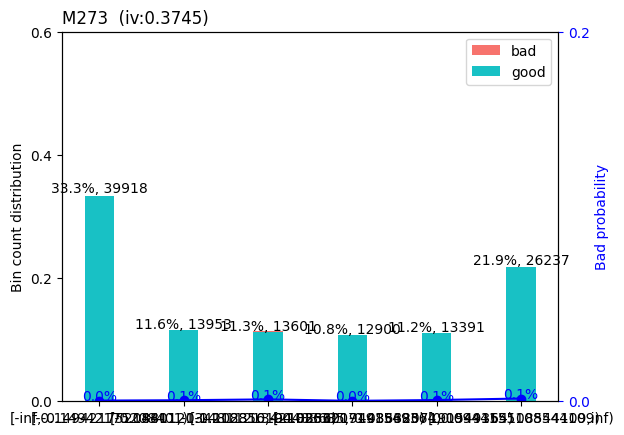

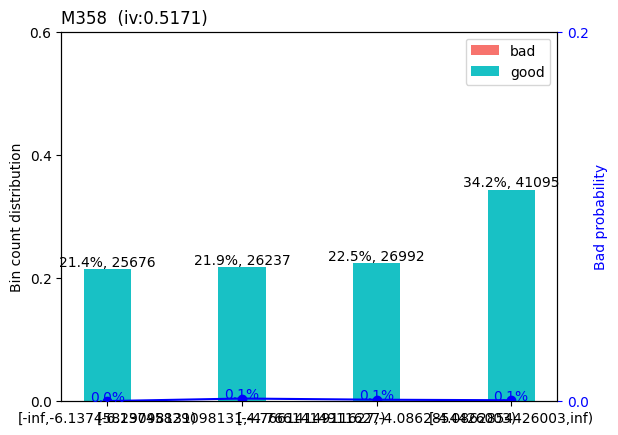

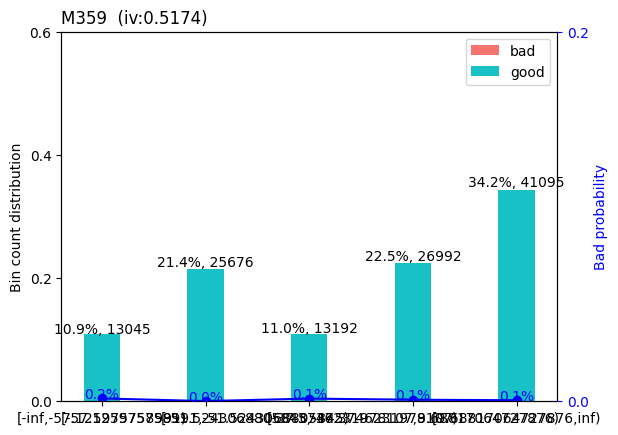

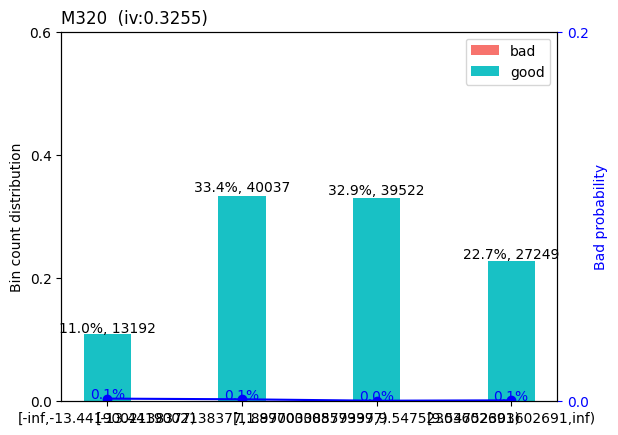

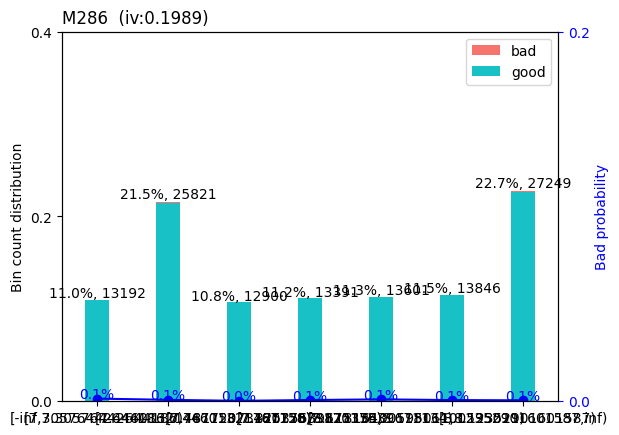

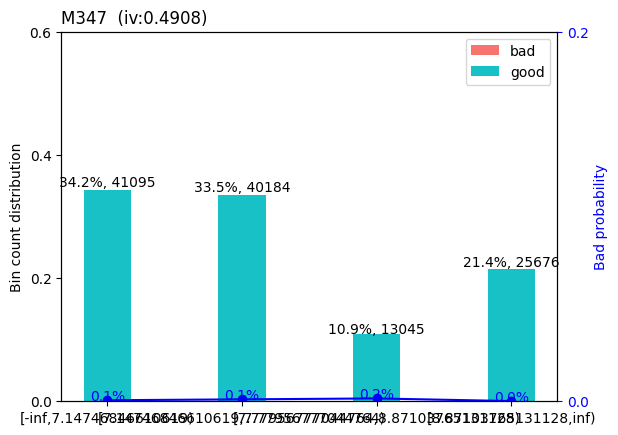

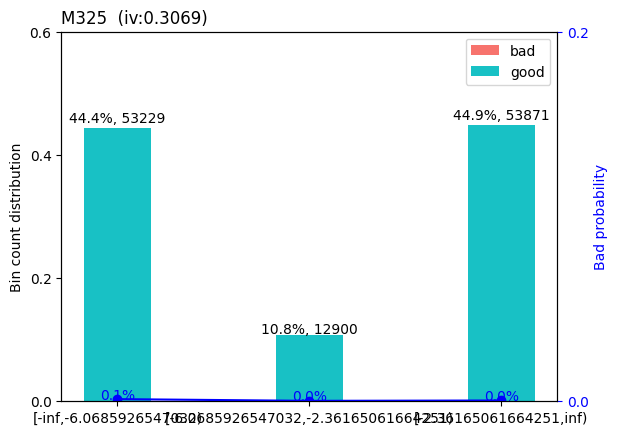

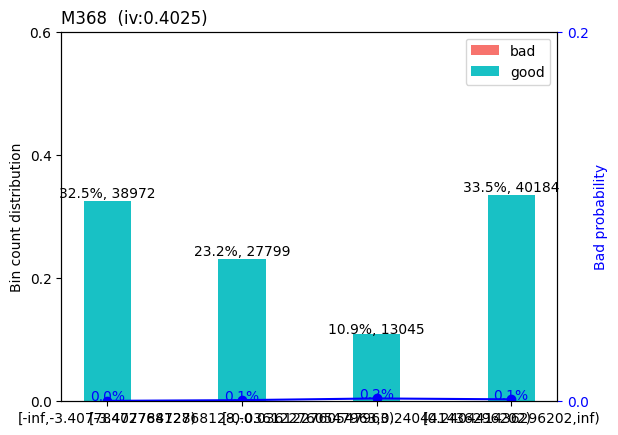

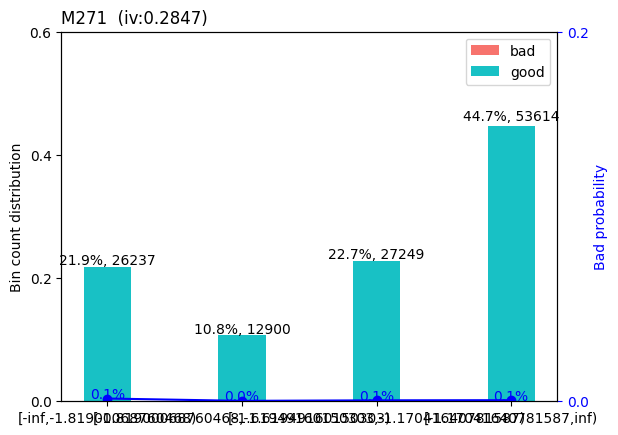

In [18]:
%%time
sc.woebin_plot(bins)

In [19]:
%%time
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
Woe transformating on 84000 rows and 56 columns in 00:00:12
[INFO] converting into woe values ...
CPU times: user 16.8 s, sys: 573 ms, total: 17.3 s
Wall time: 17.8 s


In [20]:
%%time
y_train = train_woe.loc[:,'def_trig']
X_train = train_woe.loc[:,train_woe.columns != 'def_trig']
y_test = test_woe.loc[:,'def_trig']
X_test = test_woe.loc[:,train_woe.columns != 'def_trig']

CPU times: user 43.7 ms, sys: 15.9 ms, total: 59.6 ms
Wall time: 58.5 ms


In [21]:
%%time
# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
# lr.coef_
# lr.intercept_

CPU times: user 7.45 s, sys: 110 ms, total: 7.56 s
Wall time: 7.59 s


/home/amol-murme/SBM/myenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.9, n_jobs=-1, penalty='l1', solver='saga')

In [41]:
%%time
# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

CPU times: user 633 ms, sys: 1.22 s, total: 1.85 s
Wall time: 489 ms


In [42]:

# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")


ValueError: Number of rows must be a positive integer, not 1.0

<Figure size 640x480 with 0 Axes>

In [43]:
%%time
# score ------
card = sc.scorecard(bins, lr, X_train.columns)

CPU times: user 164 ms, sys: 702 µs, total: 164 ms
Wall time: 160 ms


In [44]:
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

/home/amol-murme/SBM/myenv/lib/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


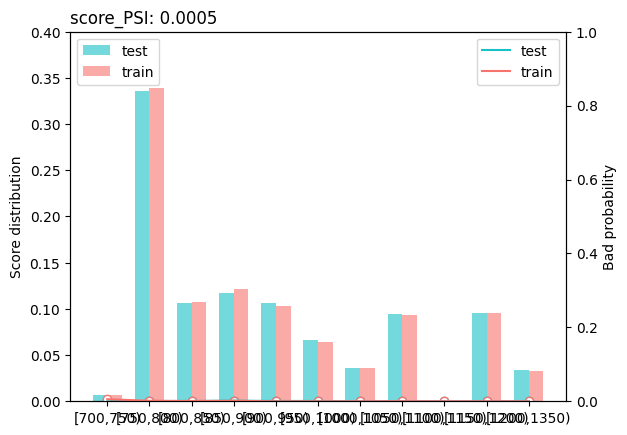

{'psi':   variable       PSI
 0    score  0.000492,
 'pic': {'score': <Figure size 640x480 with 2 Axes>}}

In [46]:
# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)